# Introduction to multiphysics modeling of sizing scenarios
*Written by Marc Budinger, INSA Toulouse, France*

The aim of this section is to illustrate how multiphysics modelling with localised parameters can be used to derive requirements from a system level, such as a rocket, to a sub-system level, such as a TVC actuation system. We will illustrate here how the maximum forces and speeds of a nozzle actuator can be obtained:
- using a Modelica model  
- using a numerical simulation of the corresponding equations in Python


## Nozzle modeling

The nozzle is composed of:
- a flexible bearing or flexseal which links the nozzle to the launcher and enables rotational movement. The equivalent characteristics and parameters for this flexible bearing are:
    - a stiffness of 1.52E+04 Nm/deg.
    - a viscous damping of 1.74E+02	Nms/deg
- a rigid cone modeled here as: 
    - an inertia of 1.40E+03 kg.m^2
    
*P80 Nozzle (from [ESA presentation](http://www.ingaero.uniroma1.it/attachments/1609_VEGA%20%20sapienza%20small.pdf))*:
![P80](./figures/nozzle.png)

The EMA (Electro Mechanical Actuator) is between 2 points of the following drawing. The given values correspond to a nominal case. The lever arm for these nominal dimensions is 1.35 m at neutral position. The variation of lever arm with position order is assumed to be negligeable here due to the small nozzle deflection (+/- 5.7° max)

*Actuator implantation*:  
![Actuator implantation](./figures/ImplantationNozzle.png)


In [1]:
import math
import numpy as np

# Definition of nozzle equivalent parameters with engineering units
Jnozzle= 1.40E+03 # [kg.m2] Inertia
Knozzle= 1.52E+04 # [Nm/deg] Stiffness
Fnozzle= 1.74E+02 # [Nms/deg] Viscous damping

# Calculate SI unit values of Knozzle and Fnozzle
# pi value is math.pi
Knozzle = Knozzle / (math.pi/180)
Fnozzle = Fnozzle / (math.pi/180)

# Lever arm
Larm=1.35 # [m] Equivalent lever arm 

> **Exercice**: Propose a diagram made up of rotational inertia, torsional stiffness and viscous friction to represent the nozzle. Complete it to represent the EMA actuator, assumed here to be a source of force.

:::{dropdown} Quiz  
Select the diagram corresponding to the previous question: Propose a diagram made up of rotational inertia, torsional stiffness and viscous friction to represent the nozzle.
![Quiz images](./figures/NozzleDiagram.PNG)
:::

:::{dropdown} Modelica diagram  
Below is the Modelica diagram equivalent to a nozzle. The linear actuator will provide a force that will generate a rotation of this mechanical load. 

*Modelica diagram of the mechanical load*: 
![Modelica diagram](./figures/NozzleModelicaModel.png)

**Note:** You can install OpenModelica from this [link](https://openmodelica.org/download/download-windows/) to simulate the Modelica [models](./modelica/TVC_SizingScenario.mo) of this course. 
:::

## Sizing scenarios

The requirements at launcher level, particularly in terms of flight stability, can be used to generate typical displacement profiles at nozzle level. These profiles can be used on test benches to qualify the performance of the system produced.

*Angle order (°) function of time (s)*:  
```{figure} ./figures/DeflectionAngle.PNG
:name: Angle_order
:align: center
:width: 50%
```

> **Question:** What do you think of this profile? 

:::{dropdown} Answer   
These are orders from the on-board computer, but they cannot be perfectly respected because they would require infinite acceleration and infinite power.
:::

In addition to these order profiles, there are response times which may depend on the amplitude: for example, 72 ms response time for 0.5° level variations. We'll assume for the rest that the most critical demand is a step of 5.2 to 5.7° angle of deflection to be performed in 72 ms.

> **Question:** How do you generate a realistic nozzle angle profile from this requirement?

:::{dropdown} Answer   
It can be assumed that the closed-loop system will respond as a second-order transfer function. The response or settling time (5%) requirement can then be expressed as a bandwidth.

$H(p)=\frac{1}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$  
with $\xi=0.7$ and thus $t_{r5}=\frac{2.9}{\omega_0}$  


*Settling time*:  
```{figure} ./figures/SettlingTime.png
:name: Settling_time
:align: center
:width: 50%
```
:::



### Modelica implementation

The nozzle load model can be combined with a force source (representing the linear actuator) and a position control loop. Modelica has a block that allows the inverse model by requiring two inputs and two outputs to be identical. It can be used as an ideal zero error corrector. In particular, it avoids the tedious calculation of a corrector at the start of the project. However, it is necessary to filter the setpoint in order to obtain realistic movements. 

*Global model*:  
```{figure} ./figures/IdealCorrectorModelica.PNG
:name: GlobalModel
:align: center
:width: 50%
```

Simulations can produce: changes in position, speed and acceleration, as well as the forces to be applied. 

### Python implementation

The scipy package can be used to calculate step responses to transfer functions. 

Velocities and accelerations are easily obtained by adding derivatives to the transfer functions:  

- position $\frac{1}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$

- speed $\frac{p}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$

- acceleration $\frac{p^2}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$

For linear models that can be represented by transfer functions or state models, it is possible to use the function [`scipy.signal.step`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html) to calculate the desired response.

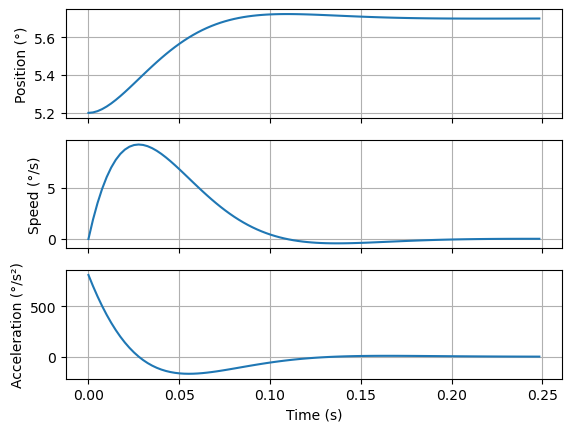

In [10]:
# Import from scipy of the step response
from scipy.signal import step

# Definition of time response, damping coef, and angular frequency of the filter
tr=72e-3
w0=2.9/tr
eps=0.7

# position calculation with a second order step response
num = [1.]
den = [1/w0**2, 2*eps/w0, 1]
t, y = step(system=(num, den))
y = 5.2 + .5*y

# speed, we change here only the numerator of the transfer function
nump = [1., 0.]
t, yp = step(system=(nump, den))
yp=0.5*yp

# acceleration
nump = [1., 0., 0.]
t, ypp = step(system=(nump, den))
ypp=0.5*ypp

# plot of the different dynamic answers
import matplotlib.pyplot as plt

f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax1.plot(t,y)
ax1.set_ylabel('Position (°)')
ax1.grid()
ax2.plot(t, yp)
ax2.set_ylabel('Speed (°/s)')
ax2.grid()
ax3.plot(t,ypp)
ax3.set_ylabel('Acceleration (°/s²)')
ax3.set_xlabel('Time (s)')
ax3.grid()
plt.show()



For potentially non-linear systems represented by a set of differential equations and algebraic equations, it is possible to use the function [`scipy.integrate.odeint`](https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations) to numerically integrate the system model.  

`scipy.integrate.odeint` requires three inputs:

```python
y = odeint(model, y0, t)
```

__model__: Function name that returns derivative values at requested y and t values as dydt = model(y,t)

__y0__: Initial conditions of the differential states

__t__: Time points at which the solution should be reported. Additional internal points are often calculated to maintain accuracy of the solution but are not reported.

> **Question:** Transform the previous transfert function $H(p)=\frac{\theta(p)}{\theta_{order}(p)}=\frac{1}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$ representation into differential equations usable by `scipy.integrate.odeint`.

:::{dropdown} Answer   
$H(p)=\frac{\theta(p)}{\theta_{order}(p)}=\frac{1}{1+\frac{2\xi p}{\omega_0}+\frac{p^2}{\omega_0^2}}$   
is equivalent to this differential equation   
$\theta(t) +\frac{2\xi}{\omega_0} \dot\theta(t) + \frac{1}{\omega_0^2} \ddot\theta(t) = \theta_{order}(t)$   
and the `model` function can be set up with the following vectors:  
$y=$ 
$\left(\begin{matrix}
        \theta(t)\\
        \dot\theta(t)        
\end{matrix}\right)$  
and  
$\dot y=$ 
$\left(\begin{matrix}
        \dot\theta(t)\\
        \omega_0^2 (\theta_{order}(t) - \theta(t)) -2\xi\omega_0 \dot\theta(t)
\end{matrix}\right)$
:::

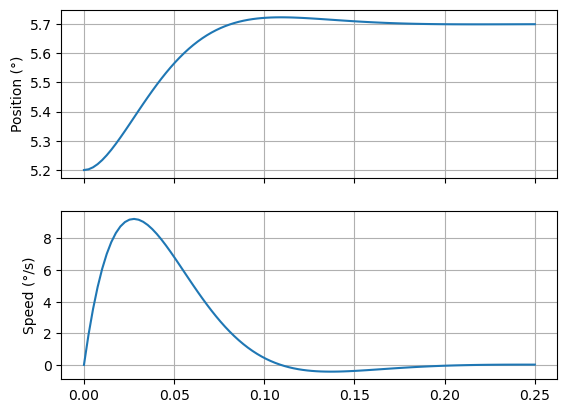

In [9]:
# Import from scipy of odeint solver
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Definition of time response, damping coef, and angular frequency of the filter
tr=72e-3
w0=2.9/tr
Xsi=0.7

# function that returns dy/dt
def model(y,t):
    theta_order=5.7 if t>0 else 0
    theta = y[0]
    thetap = y[1]
    thetapp = w0**2*(theta_order-theta)-2*Xsi*w0*thetap
    dydt = [thetap,thetapp]
    return dydt

# initial condition
y0 = [5.2,0]

# time points
t = np.linspace(0,0.25,100) 

# solve ODE
y_odeint = odeint(model,y0,t)

# plot of the different dynamic answers
f, (ax1,ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(t,y_odeint[:,0])
ax1.set_ylabel('Position (°)')
ax1.grid()
ax2.plot(t, y_odeint[:,1])
ax2.set_ylabel('Speed (°/s)')
ax2.grid()
plt.show()


### Static sizing scenario


The maximal angular displacement is 5.7°. The corresping force can be calculated thanks the flexible bearing stiffness.

In [4]:
teta_max=5.7*math.pi/180

Fstat_max=Knozzle*teta_max/Larm

print("The maximum static force is %4.2e N."%Fstat_max)

The maximum static force is 6.42e+04 N.


It's now possible to calculate the force of the actuator which is requested to respect this mission profile.

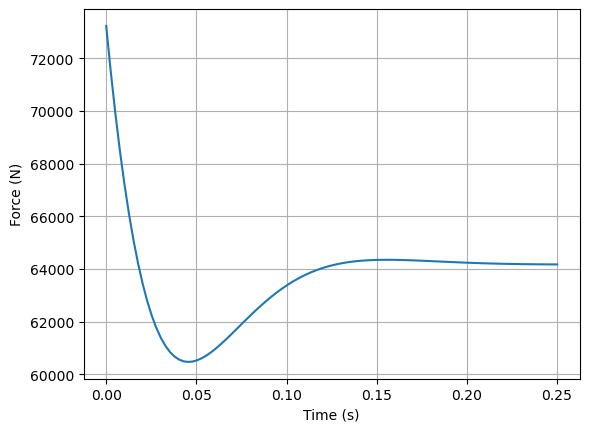

In [5]:
# degree to rad
teta, tetap, tetapp = math.pi/180*y, math.pi/180*yp, math.pi/180*ypp

# Force calculation
Fdyn=(Jnozzle*tetapp+Fnozzle*tetap+Knozzle*teta)/Larm

g, gx1 = plt.subplots(1,1, sharex=True)
gx1.plot(t,Fdyn)
gx1.set_ylabel('Force (N)')
gx1.set_xlabel('Time (s)')
gx1.grid()
plt.show()

### Force speed diagram 

This sizing scenarios can be represented on a force-speed diagram usefull for compenent selection.


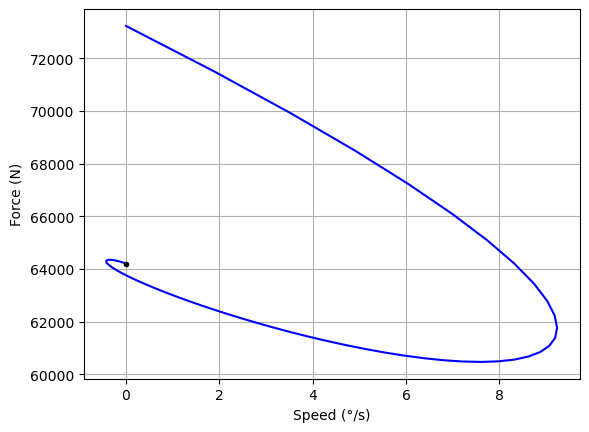

In [6]:
# we create here a force-speed diagram
h, hx1 = plt.subplots(1,1, sharex=True)
hx1.plot(yp,Fdyn,'b',0,Fstat_max,'.k')
hx1.set_ylabel('Force (N)')
hx1.set_xlabel('Speed (°/s)')
hx1.grid()
plt.show()

### Derived requirements

For the next sizing steps, the following derived requirements can be used:
- the nozzle max speed (step response)
- the max static torque (max deflexion)
- for max dynamic point (step response) : Max force with acceleration
    
In the nozzle frame (rotational movement):

In [7]:
print("Max nozzle rotational speed: %4.2f °/s"%max(yp))
print("Max static torque : %4.2f N.m"%(Knozzle*teta_max))
print("Max dynamic torque : %4.2f N.m and max acceleration : %4.2f °/s²"%(max(Fdyn)*Larm,max(ypp)))


Max nozzle rotational speed: 9.24 °/s
Max static torque : 86640.00 N.m
Max dynamic torque : 98860.13 N.m and max acceleration : 811.15 °/s²


For the linear actuator (translational movement):

In [8]:
print("Lever arm: %4.2f m"%Larm)
print("Max linear speed: %4.2f m/s"%(max(yp)*np.pi/180*Larm))
print("Max static force: %4.2f N"%(Knozzle*teta_max/Larm))
print("Max dynamic force: %4.2f N and max acceleration: %4.2f m/s²"%(max(Fdyn),max(ypp)*Larm**np.pi/180))

Lever arm: 1.35 m
Max linear speed: 0.22 m/s
Max static force: 64177.78 N
Max dynamic force: 73229.72 N and max acceleration: 11.57 m/s²


## Homework

> Read the following article in order to developp a transient simulation of thermal response of a cubesat.   

[Rossi, 2013] Rossi, S., & Ivanov, A. (2013, September). Thermal model for cubesat: A simple and easy model from the Swisscube’s thermal flight data. In Proceedings of the International Astronautical Congress (Vol. 13, pp. 9919-9928). [Link](https://www.researchgate.net/publication/299535685_THERMAL_MODEL_FOR_CUBESAT_A_SIMPLE_AND_EASY_MODEL_FROM_THE_SWISSCUBE%27S_THERMAL_FLIGHT_DATA) 

## References 

[Budinger, 2019] Budinger, M., Hazyuk, I., & Coïc, C. (2019). Multi-physics Modeling of Technological Systems. John Wiley & Sons.
